In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score,roc_auc_score
import lightgbm as lgb
from mochi import runXGB,f_beta_01,runLGBM
from sklearn.ensemble import RandomForestClassifier as RFC #sklearn 0.19

In [2]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))
print(config.feature_dict.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'chi_test_result', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'normalized_features', 'normalized_path', 'numerical_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']
dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])


### building the original hcc features

In [3]:
login_tt = pd.read_csv(data_path+'login_tt.csv')
trade_tt = pd.read_csv(data_path+'trade_tt.csv')
trade_tt_with_recent_logins = pd.read_csv(data_path+'trade_tt_with_recent_3_log_id.csv')

In [4]:
trade_tt_with_recent_logins = trade_tt_with_recent_logins.merge(login_tt,how = 'left',left_on = 'recent_login_id_0',right_on = 'log_id'
                                                               ,suffixes = ['','_login'])

In [5]:
trade_tt_hcc = trade_tt_with_recent_logins[['rowkey','id','city','ip','device']].fillna(-10)

### Check Id distribution and determine the threshold

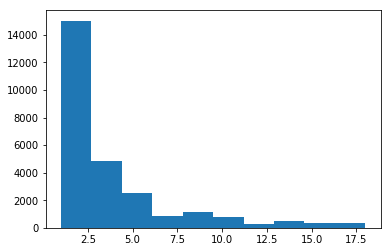

In [6]:
#id
trade_tt_hcc_times = trade_tt_hcc[['id']].groupby('id').size()
qt_trade_tt_hcc = trade_tt_hcc_times.quantile(.95)
plt.hist(trade_tt_hcc_times[trade_tt_hcc_times< qt_trade_tt_hcc])
plt.show()

In [7]:
#refill the id, change the small ones
trade_tt_hcc_times =  trade_tt_hcc[['id']].groupby('id').size().reset_index().rename(columns = {0:'id_freq'})
trade_tt_hcc = trade_tt_hcc.merge(trade_tt_hcc_times,on = 'id')
trade_tt_hcc.loc[trade_tt_hcc['id_freq']<10,'id']=-5

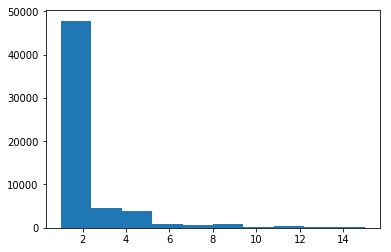

In [8]:
#ip
trade_tt_hcc_times = trade_tt_hcc[['ip']].groupby('ip').size()
qt_trade_tt_hcc = trade_tt_hcc_times.quantile(.99)
plt.hist(trade_tt_hcc_times[trade_tt_hcc_times< qt_trade_tt_hcc])
plt.show()

In [9]:
trade_tt_hcc_times =  trade_tt_hcc[['ip']].groupby('ip').size().reset_index().rename(columns = {0:'ip_freq'})
trade_tt_hcc = trade_tt_hcc.merge(trade_tt_hcc_times,on = 'ip')
trade_tt_hcc.loc[trade_tt_hcc['ip_freq']<6,'ip']=-5

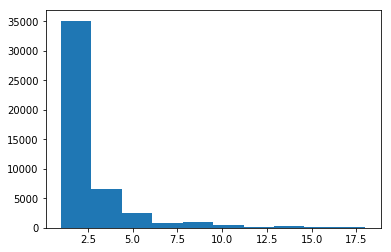

In [10]:
#device
trade_tt_hcc_times = trade_tt_hcc[['device']].groupby('device').size()
qt_trade_tt_hcc = trade_tt_hcc_times.quantile(.99)
plt.hist(trade_tt_hcc_times[trade_tt_hcc_times< qt_trade_tt_hcc])
plt.show()

In [11]:
trade_tt_hcc_times =  trade_tt_hcc[['device']].groupby('device').size().reset_index().rename(columns = {0:'device_freq'})
trade_tt_hcc = trade_tt_hcc.merge(trade_tt_hcc_times,on = 'device')
trade_tt_hcc.loc[trade_tt_hcc['device_freq']<6,'device']=-5

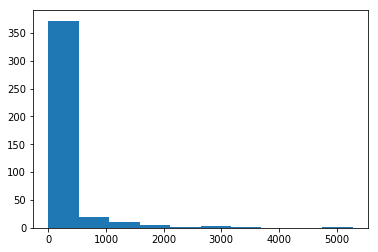

In [12]:
#device
trade_tt_hcc_times = trade_tt_hcc[['city']].groupby('city').size()
qt_trade_tt_hcc = trade_tt_hcc_times.quantile(.99)
plt.hist(trade_tt_hcc_times[trade_tt_hcc_times< qt_trade_tt_hcc])
plt.show()

In [13]:
trade_tt_hcc_times =  trade_tt_hcc[['city']].groupby('city').size().reset_index().rename(columns = {0:'city_freq'})
trade_tt_hcc = trade_tt_hcc.merge(trade_tt_hcc_times,on = 'city')
trade_tt_hcc.loc[trade_tt_hcc['city_freq']<20,'city']=-5

In [19]:
for feature in ['id','city','ip','device']:
    pd.to_pickle(trade_tt_hcc[feature].values,feature_path+feature+'.pkl')

In [15]:
config.feature_dict['ori_hcc_feature'] = ['id','city','ip','device']
pd.to_pickle(config,'config.pkl')

### testing

In [20]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
             config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
            config.feature_dict['hcc_target_encoding']+
                    config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']+
              config.feature_dict['ori_hcc_feature']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)
#trade_tt_mat[trade_tt_mat==-10]=np.nan

validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [28]:
lgbm_features = config.model_features['Lgbm_best_171']#
lgbm_features_ori_index = [features.index(x) for x in lgbm_features]
trade_tt_lgbm = trade_tt_mat[:,lgbm_features_ori_index]

new_features = config.model_features['Lgbm_best_171']+config.feature_dict['ori_hcc_feature']
new_features_ori_index = [features.index(x) for x in new_features]
trade_tt_new = trade_tt_mat[:,new_features_ori_index]

In [26]:
    cv_scores = []
    cv_result = []
    models = []
    
    i = 0
    
    for train_indice,val_indice in validation_tuple_list:
        #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
        #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
        result_dict = {}
        
        #filter the features
        dev_X, val_X = trade_tt_lgbm[train_indice], trade_tt_lgbm[val_indice]
        dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
       
        preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=lgbm_features,verbose=100,eta=0.02,
                              early_stop=100,num_rounds=10000,watch_dict=result_dict,feval = None,
                              bagging_fraction=0.75,feature_fraction=0.25,num_leaves=64)
        """
        preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                              early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
         """
        
        #result_f_beta = f_beta_01(val_y.values, preds>0.5)
        result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
        
        cv_scores.append(result_f_beta)
        cv_result.append(result_dict)
        models.append(model)
        i+=1
        print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))
    
    print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.998539	test's auc: 0.989618
[200]	train's auc: 0.999741	test's auc: 0.990555
Early stopping, best iteration is:
[165]	train's auc: 0.999403	test's auc: 0.990976
f_beta score for the turn 1 is 0.914226855609
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.999179	test's auc: 0.963289
[200]	train's auc: 0.999826	test's auc: 0.965382
Early stopping, best iteration is:
[152]	train's auc: 0.999623	test's auc: 0.966053
f_beta score for the turn 2 is 0.891423813489
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.999297	test's auc: 0.986897
[200]	train's auc: 0.999889	test's auc: 0.988063
[300]	train's auc: 0.999997	test's auc: 0.988326
Early stopping, best iteration is:
[244]	train's auc: 0.999968	test's auc: 0.988698
f_beta score for the turn 3 is 0.925181726848
Training until validation scores don't improve for 100 rounds.
[100]	train's a

In [29]:
    cv_scores = []
    cv_result = []
    models = []
    
    i = 0
    for train_indice,val_indice in validation_tuple_list:
        #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
        #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
        result_dict = {}
        
        #filter the features
        dev_X, val_X = trade_tt_new[train_indice], trade_tt_new[val_indice]
        dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
       
        preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=new_features,verbose=100,eta=0.02,
                              early_stop=100,num_rounds=10000,watch_dict=result_dict,feval = None,
                              bagging_fraction=0.75,feature_fraction=0.25,num_leaves=64)
        """
        preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                              early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
         """
        
        #result_f_beta = f_beta_01(val_y.values, preds>0.5)
        result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
        
        cv_scores.append(result_f_beta)
        cv_result.append(result_dict)
        models.append(model)
        i+=1
        print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))
    
    print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.998492	test's auc: 0.987659
[200]	train's auc: 0.999784	test's auc: 0.991371
Early stopping, best iteration is:
[191]	train's auc: 0.999711	test's auc: 0.991557
f_beta score for the turn 1 is 0.918240604392
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.999144	test's auc: 0.963391
[200]	train's auc: 0.999838	test's auc: 0.970357
Early stopping, best iteration is:
[180]	train's auc: 0.99962	test's auc: 0.970548
f_beta score for the turn 2 is 0.906519898391
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.999357	test's auc: 0.986227
[200]	train's auc: 0.999901	test's auc: 0.986904
[300]	train's auc: 0.999997	test's auc: 0.98713
Early stopping, best iteration is:
[249]	train's auc: 0.999974	test's auc: 0.987693
f_beta score for the turn 3 is 0.909647249004
Training until validation scores don't improve for 100 rounds.
[100]	train's auc